In [1]:
# Creating the entry point for spark 
from pyspark import SparkContext,SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.getOrCreate()

# Importing the below modules for data manipulation
from pyspark.sql.functions import count

In [2]:
# To handle matrix & array computations
import numpy as np

# to handle data in form of rows and columns
import pandas as pd

# importing ploting libraries
import matplotlib.pyplot as plt

from scipy.stats import itemfreq

# For visualization
import seaborn as sns

# For train & test split
from sklearn.model_selection import train_test_split

# For plotting inline in Jupyter notebook
%matplotlib inline

# datetime processing
from datetime import datetime

# Data Preprocessing
from sklearn import preprocessing

# For conducting statistical tests
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For creating regression Models using LinearRegression, Stochastic Gradient Descent regression, Decision Tree, RandomForest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# For calculating cross validation score
from sklearn.model_selection import cross_val_score

# For calculating different metrics like R2, mean abolute error and mean squared error
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# For identifying and setting best hypertuning parameters for the model
from sklearn.model_selection import GridSearchCV

# For creating decision tree in graphical mode
import graphviz 
from sklearn.tree import export_graphviz

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

/usr/local/anaconda/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Hypothesis
# Oil price plays a role in the total number of sales transactions & sales

In [4]:
# Loading Merged train daily transactions for store 44

In [5]:
sdfTrain = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_transactions_daily_store44.csv",header = True,inferSchema = True)

In [6]:
sdfTrain.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- unit_sales: double (nullable = true)



In [7]:
sdfTrain.count()

1089

In [8]:
print(sdfTrain.show(5))

+-------------------+---------+------------+-----------------+
|               date|store_nbr|transactions|       unit_sales|
+-------------------+---------+------------+-----------------+
|2014-07-02 00:00:00|       44|        4494|50616.44199999999|
|2014-07-03 00:00:00|       44|        3849|        34998.176|
|2014-07-04 00:00:00|       44|        4111|35662.77099999999|
|2014-07-05 00:00:00|       44|        4674|50965.70800000001|
|2014-07-06 00:00:00|       44|        5092|64146.52700000003|
+-------------------+---------+------------+-----------------+
only showing top 5 rows

None


In [9]:
sqlContext.registerDataFrameAsTable(sdfTrain, "sdfTrainTbl")

<b><u> Merge Train and Oil:</u></b>

In [10]:
sdfOil = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/oil_2013_2015_interpolated.csv",header = True,inferSchema = True)

In [11]:
sdfOil.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- dcoilwtico: double (nullable = true)



In [12]:
sdfOil.count()

1095

In [13]:
minRow = sdfOil.agg({"date": "min"}).collect()[0]
print minRow["min(date)"]

2013-01-01 00:00:00


In [14]:
maxRow = sdfOil.agg({"date": "max"}).collect()[0]
print maxRow["max(date)"]

2015-12-31 00:00:00


In [15]:
sqlContext.registerDataFrameAsTable(sdfOil, "sdfOilTbl")

In [16]:
# Merge Training dataset with interpolated oil dataset

In [17]:
sdfTrainWithOil = sdfTrain.join(sdfOil, ["date"],"leftouter")

In [18]:
print(sdfTrainWithOil.show(20))

+-------------------+---------+------------+------------------+------------------+
|               date|store_nbr|transactions|        unit_sales|        dcoilwtico|
+-------------------+---------+------------+------------------+------------------+
|2014-07-02 00:00:00|       44|        4494| 50616.44199999999|            105.18|
|2014-07-03 00:00:00|       44|        3849|         34998.176|            104.76|
|2014-07-04 00:00:00|       44|        4111| 35662.77099999999|          104.6175|
|2014-07-05 00:00:00|       44|        4674| 50965.70800000001|           104.475|
|2014-07-06 00:00:00|       44|        5092| 64146.52700000003|          104.3325|
|2014-07-07 00:00:00|       44|        4013|         37039.867|            104.19|
|2014-07-08 00:00:00|       44|        3643|31809.408000000007|            104.06|
|2014-07-09 00:00:00|       44|        4083|40275.270000000004|            102.93|
|2014-07-10 00:00:00|       44|        3780|29022.608999999997|            103.61|
|201

In [19]:
sdfTrainWithOil.count()

1089

<b><u>Merge Train and Holiday_events:</u></b>

In [20]:
sdfHolidayEvents = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015_noduplicates.csv",header = True,inferSchema = True)

In [21]:
print(sdfHolidayEvents.show(5))

+-------------------+--------+--------+-----------+--------------------+-----------+
|               date|    type|  locale|locale_name|         description|transferred|
+-------------------+--------+--------+-----------+--------------------+-----------+
|2013-01-01 00:00:00| Holiday|National|    Ecuador|  Primer dia del ano|      false|
|2013-01-05 00:00:00|Work Day|National|    Ecuador|Recupero puente N...|      false|
|2013-01-12 00:00:00|Work Day|National|    Ecuador|Recupero puente p...|      false|
|2013-02-11 00:00:00| Holiday|National|    Ecuador|            Carnaval|      false|
|2013-02-12 00:00:00| Holiday|National|    Ecuador|            Carnaval|      false|
+-------------------+--------+--------+-----------+--------------------+-----------+
only showing top 5 rows

None


In [22]:
sdfHolidayEvents.count()

150

In [23]:
sqlContext.registerDataFrameAsTable(sdfHolidayEvents, "sdfHolidayEvents")

In [24]:
sdfHolidayEvents.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: boolean (nullable = true)



In [25]:
sdfTrainWithOilHolidayEventsJoined = sdfTrainWithOil.join(sdfHolidayEvents, ["date"],"leftouter")

In [26]:
sqlContext.registerDataFrameAsTable(sdfTrainWithOilHolidayEventsJoined, "sdfTrainWithOilHolidayEventsJoined")

In [27]:
sqlContext.sql("select count(*) from sdfTrainWithOilHolidayEventsJoined").show()

+--------+
|count(1)|
+--------+
|    1089|
+--------+



In [28]:
minRow_Train = sdfTrainWithOilHolidayEventsJoined.agg({"date": "min"}).collect()[0]
print minRow_Train["min(date)"]

2013-01-02 00:00:00


In [29]:
maxRow_Train = sdfTrainWithOilHolidayEventsJoined.agg({"date": "max"}).collect()[0]
print maxRow_Train["max(date)"]

2015-12-31 00:00:00


In [30]:
#date_mask = (sdfTrainWithOilHolidayEventsJoined['date'] >= '2015-01-01') & (sdfTrainWithOilHolidayEventsJoined['date'] <= '2015-12-31')
pd_train = sdfTrainWithOilHolidayEventsJoined.toPandas()

#Print the size
len(pd_train)

1089

In [31]:
pd_train.head(5)

date  store_nbr  transactions  unit_sales  dcoilwtico   type  \
0 2014-07-02         44          4494   50616.442    105.1800   None   
1 2014-07-03         44          3849   34998.176    104.7600   None   
2 2014-07-04         44          4111   35662.771    104.6175  Event   
3 2014-07-05         44          4674   50965.708    104.4750  Event   
4 2014-07-06         44          5092   64146.527    104.3325   None   

     locale locale_name                                 description  \
0      None        None                                        None   
1      None        None                                        None   
2  National     Ecuador  Mundial de futbol Brasil: Cuartos de Final   
3  National     Ecuador  Mundial de futbol Brasil: Cuartos de Final   
4      None        None                                        None   

  transferred  
0        None  
1        None  
2       False  
3       False  
4        None

# Data Pre-processing

In [32]:
pd_train_nan = (pd_train.isnull().sum() / pd_train.shape[0]) * 100
pd_train_nan

date             0.00000
store_nbr        0.00000
transactions     0.00000
unit_sales       0.00000
dcoilwtico       0.00000
type            86.77686
locale          86.77686
locale_name     86.77686
description     86.77686
transferred     86.77686
dtype: float64

In [33]:
# There are 86% of Nulls/NA in Holiday events attributes. Replacing Nulls or NA with No_Holiday as the default value

In [34]:
pd_train['type'] = pd_train.type.replace(np.NaN, 'No_Holiday')
pd_train['locale'] = pd_train.locale.replace(np.NaN, 'None')
pd_train['locale_name'] = pd_train.locale_name.replace(np.NaN, 'None')
pd_train['description'] = pd_train.description.replace(np.NaN, 'None')
pd_train['transferred'] = pd_train.transferred.replace(np.NaN, 'None')

In [35]:
# Rechecking for Nulls, No Nulls now

In [36]:
pd_train_nan = (pd_train.isnull().sum() / pd_train.shape[0]) * 100
pd_train_nan

date            0.0
store_nbr       0.0
transactions    0.0
unit_sales      0.0
dcoilwtico      0.0
type            0.0
locale          0.0
locale_name     0.0
description     0.0
transferred     0.0
dtype: float64

# Generating Summary Statistics 

In [37]:
# Inference
# 1089 Observations, 10 features
# Descriptive statistics reveal: average transaction volume is 4133 between 2013 - 2015 & Monthly average sales is $30586 for store 44 for the period 2013 - 2015
# Minimum transaction volume is 2333 & Maximum transaction volume is 8359.Min sales is $9067 and Max sales is $78070
# Oil price range from  $34 to $110

In [38]:
#Shape
print('Shape : ', pd_train.shape, '\n')

#Type
print('Type : ', '\n', pd_train.dtypes)

#Summary
pd_train.describe()

('Shape : ', (1089, 10), '\n')
('Type : ', '\n', date            datetime64[ns]
store_nbr                int64
transactions             int64
unit_sales             float64
dcoilwtico             float64
type                    object
locale                  object
locale_name             object
description             object
transferred             object
dtype: object)


store_nbr  transactions    unit_sales   dcoilwtico
count     1089.0   1089.000000   1089.000000  1089.000000
mean        44.0   4325.125803  32352.572317    79.983140
std          0.0    749.300106  13420.765145    24.087967
min         44.0   2333.000000   9067.748000    34.550000
25%         44.0   3797.000000  21326.734000    52.885000
50%         44.0   4133.000000  30586.076000    93.260000
75%         44.0   4787.000000  39148.231000    99.810000
max         44.0   8359.000000  78070.753000   110.620000

In [39]:
pd_train.sample(10)

date  store_nbr  transactions  unit_sales  dcoilwtico        type  \
1040 2014-05-14         44          4128   22226.754  102.630000  No_Holiday   
652  2013-04-19         44          3558   18418.771   88.040000  No_Holiday   
995  2014-03-30         44          5201   62628.939  101.623333  No_Holiday   
548  2013-01-05         44          4921   31382.508   93.146667    Work Day   
67   2014-09-07         44          6099   75814.771   92.866667  No_Holiday   
781  2013-08-26         44          3831   19270.846  105.880000  No_Holiday   
699  2013-06-05         44          4107   21612.549   93.660000  No_Holiday   
6    2014-07-08         44          3643   31809.408  104.060000       Event   
158  2014-12-07         44          5452   67381.384   64.050000  No_Holiday   
877  2013-11-30         44          5181   32135.533   92.903333  No_Holiday   

        locale locale_name                            description transferred  
1040      None        None                                   None        None  
652       None        None                                   None        None  
995       None        None                                   None        None  
548   National     Ecuador                Recupero puente Navidad       False  
67        None        None                                   None        None  
781       None        None                                   None        None  
699       None        None                                   None        None  
6     National     Ecuador  Mundial de futbol Brasil: Semifinales       False  
158       None        None                                   None        None  
877       None        None                                   None        None

In [40]:
pd_train.type.unique()

array(['No_Holiday', u'Event', u'Holiday', u'Additional', u'Transfer',
       u'Work Day', u'Bridge'], dtype=object)

In [41]:
pd_train.description.unique()

array(['None', u'Mundial de futbol Brasil: Cuartos de Final',
       u'Mundial de futbol Brasil: Semifinales',
       u'Mundial de futbol Brasil: Tercer y cuarto lugar',
       u'Mundial de futbol Brasil: Final', u'Cantonizacion de Cayambe',
       u'Fundacion de Guayaquil-1', u'Fundacion de Guayaquil',
       u'Fundacion de Esmeraldas', u'Primer Grito de Independencia',
       u'Fundacion de Riobamba', u'Fundacion de Ambato',
       u'Fundacion de Ibarra', u'Cantonizacion de Quevedo',
       u'Independencia de Guayaquil',
       u'Traslado Independencia de Guayaquil', u'Dia de Difuntos',
       u'Independencia de Cuenca', u'Provincializacion de Santo Domingo',
       u'Provincializacion Santa Elena', u'Independencia de Guaranda',
       u'Independencia de Latacunga', u'Independencia de Ambato',
       u'Black Friday', u'Cyber Monday', u'Fundacion de Quito-1',
       u'Fundacion de Quito', u'Fundacion de Loja',
       u'Recupero Puente Navidad', u'Navidad-4', u'Navidad-3',
       u'Nav

In [42]:
pd_train.locale.unique()

array(['None', u'National', u'Local', u'Regional'], dtype=object)

In [43]:
pd_train.transferred.unique()

array(['None', False, True], dtype=object)

# Data Pre-Processing

In [44]:
# Formatting date to YYYY-MM-DD

In [45]:
pd_train['date']=pd_train['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [46]:
pd_train['date'].sample(10)

737     2013-07-13
607     2013-03-05
912     2014-01-06
717     2013-06-23
925     2014-01-19
68      2014-09-08
619     2013-03-17
145     2014-11-24
836     2013-10-20
1060    2014-06-03
Name: date, dtype: object

In [47]:
pd_train.sample(10)

date  store_nbr  transactions  unit_sales  dcoilwtico        type  \
746   2013-07-22         44          3773   18184.387  106.610000  No_Holiday   
1076  2014-06-19         44          3724   18725.544  107.080000  No_Holiday   
1075  2014-06-18         44          4044   22035.203  106.640000  No_Holiday   
747   2013-07-23         44          3576   17178.475  107.130000     Holiday   
481   2015-10-28         44          3978   33815.586   45.930000  No_Holiday   
745   2013-07-21         44          4373   25648.429  107.073333  No_Holiday   
622   2013-03-20         44          3806   19657.660   93.210000  No_Holiday   
610   2013-03-08         44          3998   26132.241   92.010000  No_Holiday   
5     2014-07-07         44          4013   37039.867  104.190000  No_Holiday   
824   2013-10-08         44          3529   15810.702  103.540000  No_Holiday   

     locale locale_name               description transferred  
746    None        None                      None        None  
1076   None        None                      None        None  
1075   None        None                      None        None  
747   Local     Cayambe  Cantonizacion de Cayambe       False  
481    None        None                      None        None  
745    None        None                      None        None  
622    None        None                      None        None  
610    None        None                      None        None  
5      None        None                      None        None  
824    None        None                      None        None

In [48]:
# Reformat the date - Get Month Year
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(pd_train);

In [49]:
pd_train['date'] = pd.to_datetime(pd_train['date'])
pd_train['day'] = pd_train['date'].dt.weekday_name
pd_train = pd_train.drop('date', axis=1)

In [50]:
pd_train.sample(10)

store_nbr  transactions  unit_sales  dcoilwtico        type locale  \
1034         44          3769   16930.431  100.520000  No_Holiday   None   
373          44          4669   50342.467   52.373333  No_Holiday   None   
1017         44          3984   22809.098  104.350000     Holiday  Local   
42           44          4503   25680.017   97.570000  No_Holiday   None   
237          44          3548   16840.895   47.650000  No_Holiday   None   
122          44          4843   52467.431   79.943333  No_Holiday   None   
617          44          3732   18609.600   93.490000  No_Holiday   None   
692          44          3702   18342.311   93.130000  No_Holiday   None   
351          44          5857   63106.321   59.750000  No_Holiday   None   
134          44          3714   29556.051   74.130000  No_Holiday   None   

     locale_name                description transferred month  year        day  
1034        None                       None        None    05  2014   Thursday  
373         None                       None        None    07  2015     Sunday  
1017    Riobamba  Cantonizacion de Riobamba       False    04  2014     Monday  
42          None                       None        None    08  2014  Wednesday  
237         None                       None        None    02  2015   Thursday  
122         None                       None        None    11  2014   Saturday  
617         None                       None        None    03  2013     Friday  
692         None                       None        None    05  2013  Wednesday  
351         None                       None        None    06  2015   Saturday  
134         None                       None        None    11  2014   Thursday

In [51]:
dummy_variables = ['type','store_nbr','locale', 'locale_name','transferred', 'month', 'day']

for var in dummy_variables:
    dummy = pd.get_dummies(pd_train[var], prefix = var, drop_first = False)
    pd_train = pd.concat([pd_train, dummy], axis = 1)

pd_train = pd_train.drop(dummy_variables, axis = 1)
pd_train = pd_train.drop(['year'], axis = 1)

In [52]:
pd_train=pd_train.drop("description",axis=1)

In [53]:
pd_train.sample(10)

transactions  unit_sales  dcoilwtico  type_Additional  type_Bridge  \
326          3599   23840.864   57.290000                0            0   
748          3882   18275.443  105.410000                1            0   
311          4008   26314.777   59.230000                0            0   
893          5165   29312.315   97.180000                0            0   
272          4349   24349.005   49.130000                0            0   
558          3527   15761.721   93.260000                0            0   
318          3924   24386.601   59.440000                0            0   
240          5454   48394.660   49.673333                0            0   
412          3693   28424.410   41.000000                0            0   
343          4206   35997.924   59.960000                0            0   

     type_Event  type_Holiday  type_No_Holiday  type_Transfer  type_Work Day  \
326           0             0                1              0              0   
748           0             0                0              0              0   
311           0             0                1              0              0   
893           0             0                1              0              0   
272           0             0                1              0              0   
558           0             0                1              0              0   
318           0             0                1              0              0   
240           0             0                1              0              0   
412           0             0                1              0              0   
343           0             0                1              0              0   

         ...        month_10  month_11  month_12  day_Friday  day_Monday  \
326      ...               0         0         0           0           0   
748      ...               0         0         0           0           0   
311      ...               0         0         0           0           1   
893      ...               0         0         1           0           1   
272      ...               0         0         0           0           0   
558      ...               0         0         0           0           0   
318      ...               0         0         0           0           1   
240      ...               0         0         0           0           0   
412      ...               0         0         0           0           0   
343      ...               0         0         0           1           0   

     day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  
326             0           0             0            1              0  
748             0           0             0            0              1  
311             0           0             0            0              0  
893             0           0             0            0              0  
272             0           0             1            0              0  
558             0           0             0            1              0  
318             0           0             0            0              0  
240             0           1             0            0              0  
412             0           0             1            0              0  
343             0           0             0            0              0  

[10 rows x 57 columns]

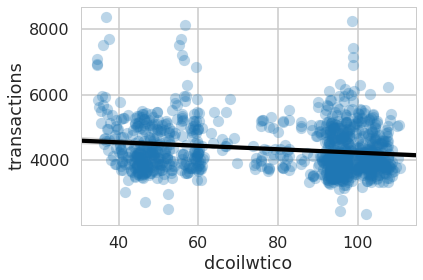

In [54]:
sns.regplot(x='dcoilwtico',
           y='transactions',
           data=pd_train,
           scatter_kws={'alpha':0.3},
           line_kws={'color':'black'})

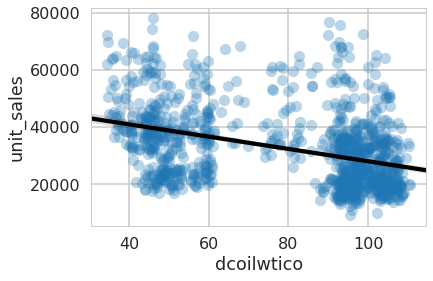

In [55]:
sns.regplot(x='dcoilwtico',
           y='unit_sales',
           data=pd_train,
           scatter_kws={'alpha':0.3},
           line_kws={'color':'black'})

In [56]:
#Re-scale Sales, Transactions, Oil Price using the standard scaler
scaler = preprocessing.StandardScaler()
pd_train['unit_sales'] = scaler.fit_transform(pd_train['unit_sales'].reshape(-1,1))
pd_train['dcoilwtico'] = scaler.fit_transform(pd_train['dcoilwtico'].reshape(-1,1))
pd_train['transactions'] = scaler.fit_transform(pd_train['transactions'].reshape(-1,1))

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/anaconda/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
pd_train.sample(10)

transactions  unit_sales  dcoilwtico  type_Additional  type_Bridge  \
138      -0.451463    0.155570   -0.180386                0            0   
269      -0.833328   -0.871900   -1.300962                0            0   
690      -1.161785   -1.189646    0.600757                0            0   
891       2.169519    0.280551    0.689050                0            0   
892       2.448574    0.726040    0.701649                0            0   
908       0.129346    1.093738    0.629519                0            0   
344       0.846344    1.557465   -0.837586                0            0   
413       0.210792    0.426104   -1.641953                0            0   
948      -0.852020   -0.990681    0.829710                0            0   
1004     -0.610351   -0.864920    0.938113                0            0   

      type_Event  type_Holiday  type_No_Holiday  type_Transfer  type_Work Day  \
138            0             0                1              0              0   
269            0             0                1              0              0   
690            0             0                1              0              0   
891            0             0                1              0              0   
892            0             0                1              0              0   
908            0             0                1              0              0   
344            0             0                1              0              0   
413            0             0                1              0              0   
948            0             0                1              0              0   
1004           0             0                1              0              0   

          ...        month_10  month_11  month_12  day_Friday  day_Monday  \
138       ...               0         1         0           0           1   
269       ...               0         0         0           0           1   
690       ...               0         0         0           0           1   
891       ...               0         0         1           0           0   
892       ...               0         0         1           0           0   
908       ...               0         0         0           0           0   
344       ...               0         0         0           0           0   
413       ...               0         0         0           1           0   
948       ...               0         0         0           0           0   
1004      ...               0         0         0           0           0   

      day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  
138              0           0             0            0              0  
269              0           0             0            0              0  
690              0           0             0            0              0  
891              1           0             0            0              0  
892              0           1             0            0              0  
908              0           0             1            0              0  
344              1           0             0            0              0  
413              0           0             0            0              0  
948              0           0             0            1              0  
1004             0           0             0            1              0  

[10 rows x 57 columns]

In [58]:
print('Shape : ', pd_train.shape)

('Shape : ', (1089, 57))


# Exploratory Data Analysis for store 44 with the prepared dataset 

In [59]:
# The features highly correlated with transactions is Unit sales, Remove unit sales from the dependent variables.
# As the number of sales increases, total sales also increases and vice versa. Hence they are highly correlated and sales can be removed.

In [60]:
import matplotlib.pyplot as plt

corr = pd_train.corr()
corr.style.background_gradient()

/usr/local/anaconda/python2/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


([<matplotlib.axis.YTick at 0x7f74daf90050>,
 <a list of 57 Text yticklabel objects>)

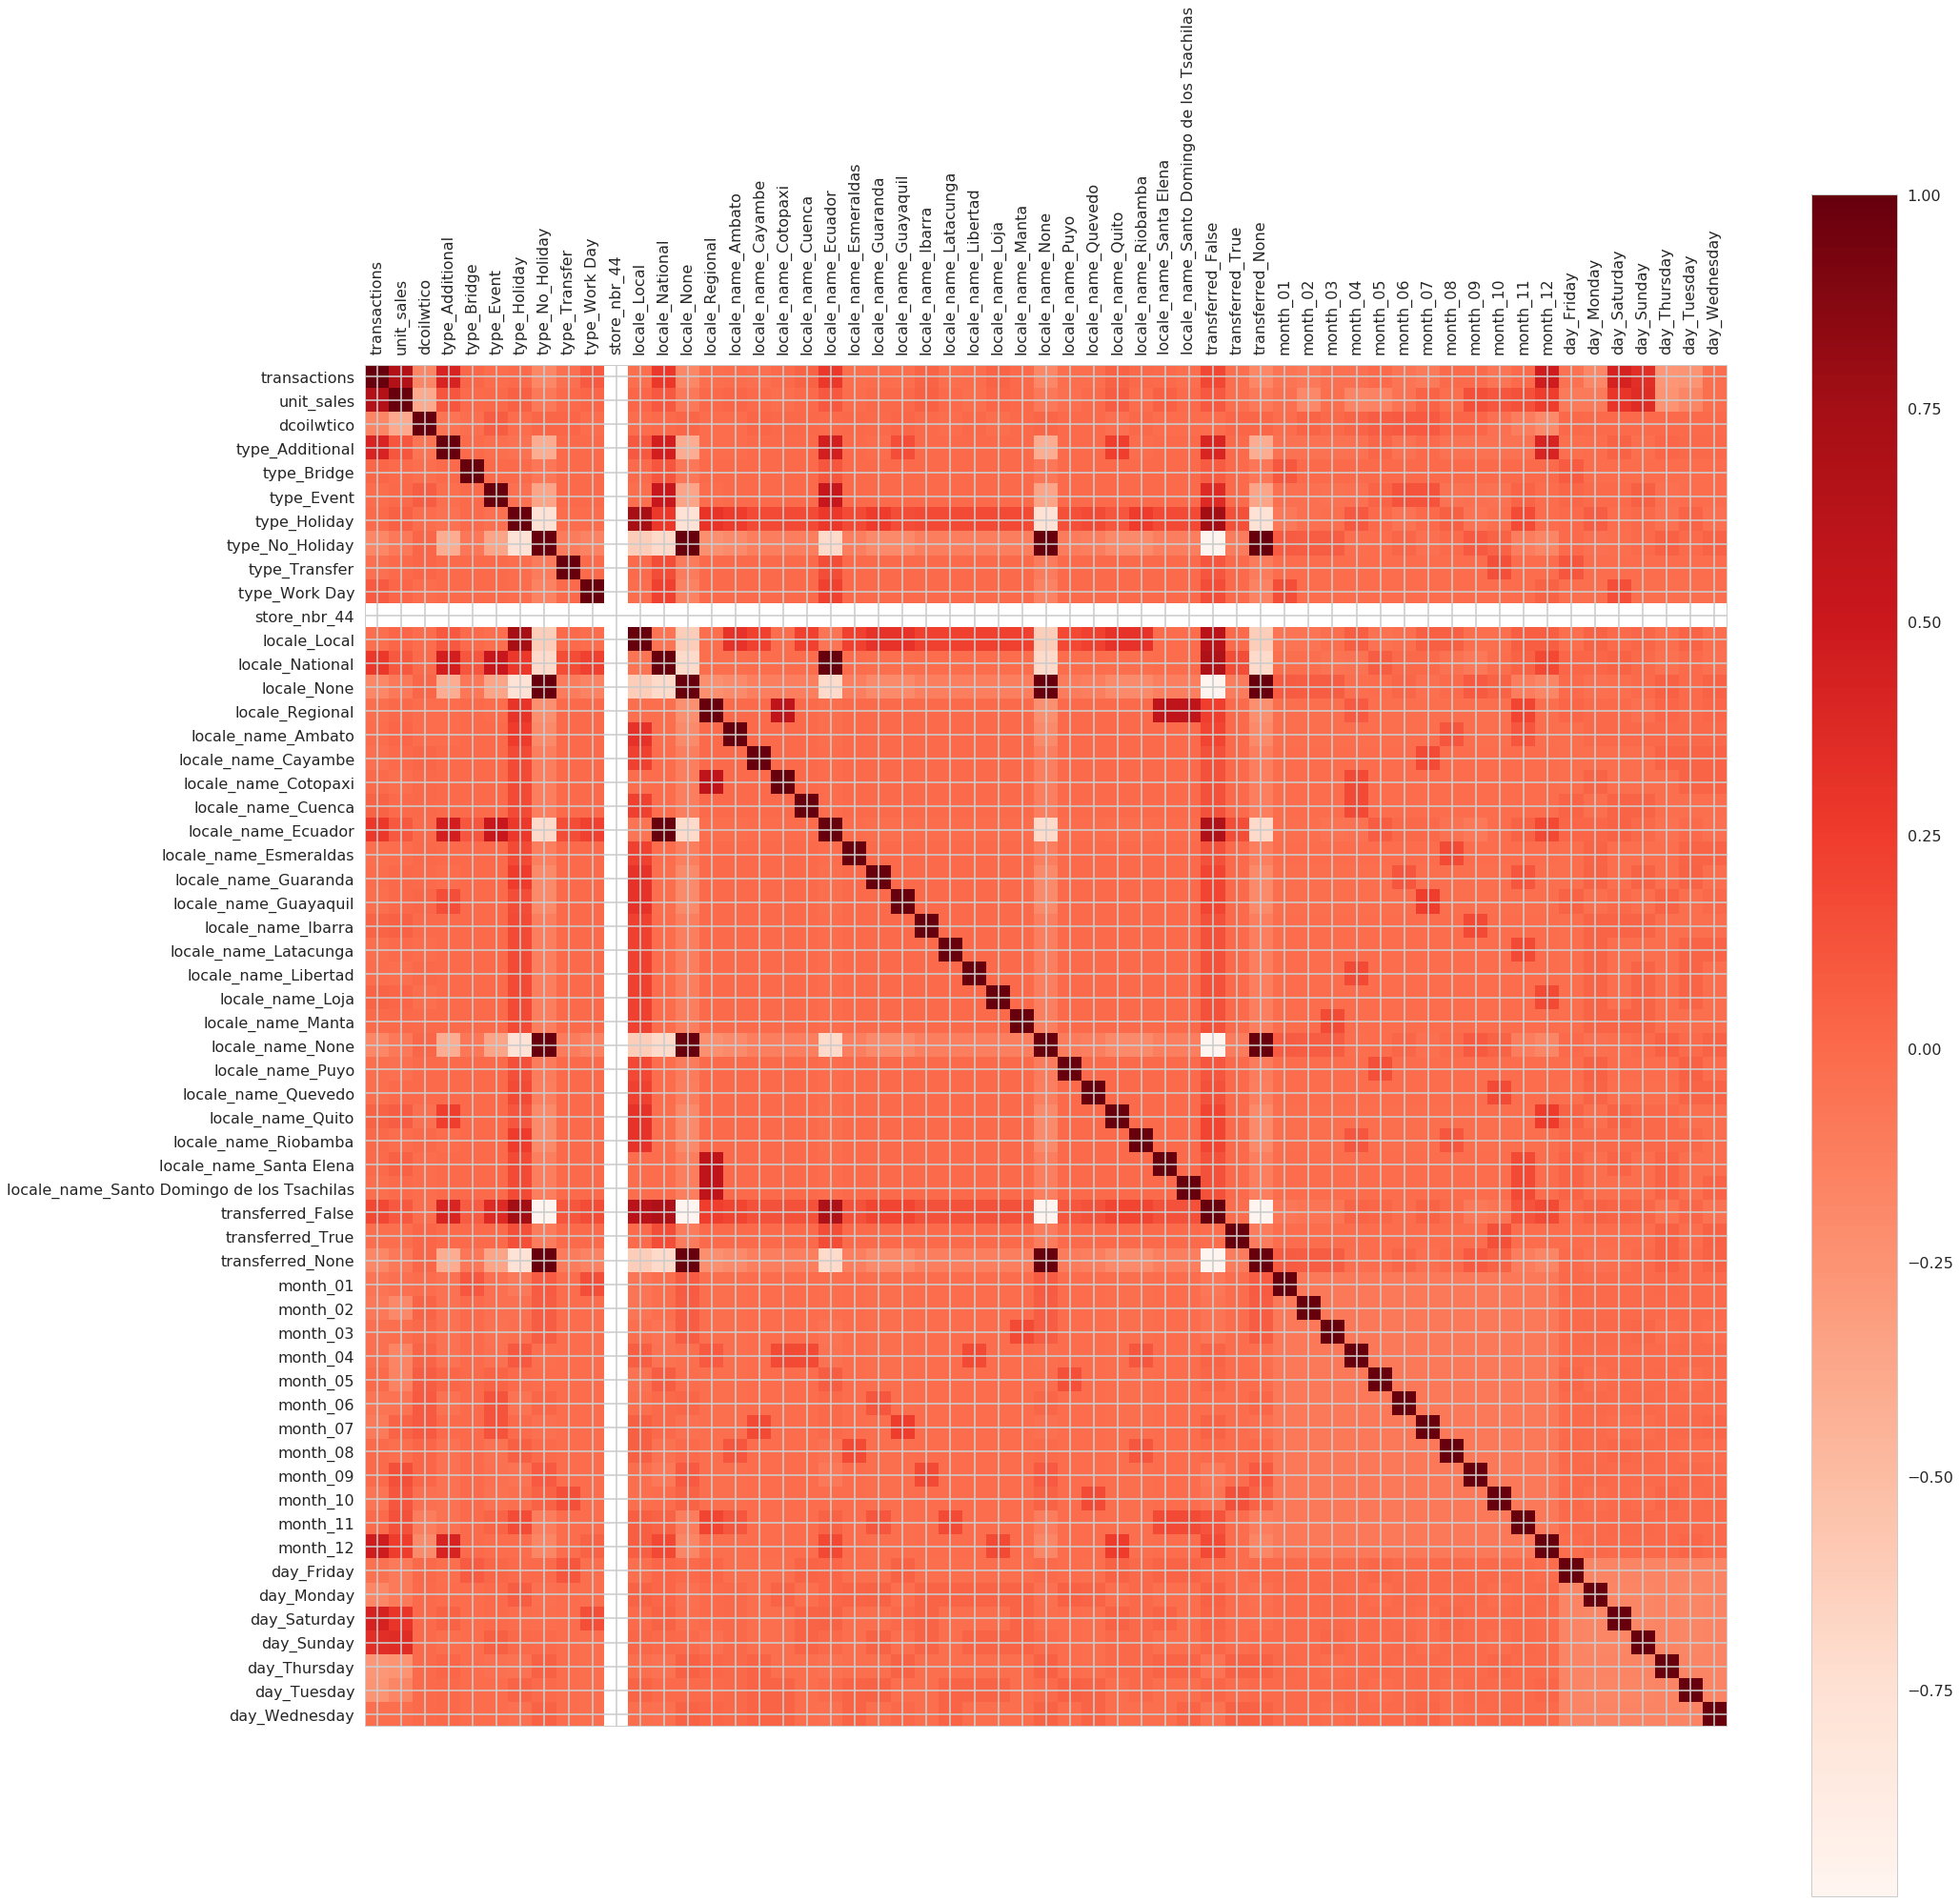

In [61]:
plt.figure(figsize=(32,32))
plt.matshow(pd_train.corr(), cmap=plt.cm.Reds, fignum=1)
plt.colorbar()
tick_marks = [i for i in range(len(pd_train.columns))]
plt.xticks(tick_marks, pd_train.columns, rotation=90)
plt.yticks(tick_marks, pd_train.columns)

In [62]:
# Keeping only the highly correlated features for plotting the distribution
pd_train_filtered = pd_train[['transactions','dcoilwtico','unit_sales','type_Additional','month_12','day_Saturday','day_Sunday']]

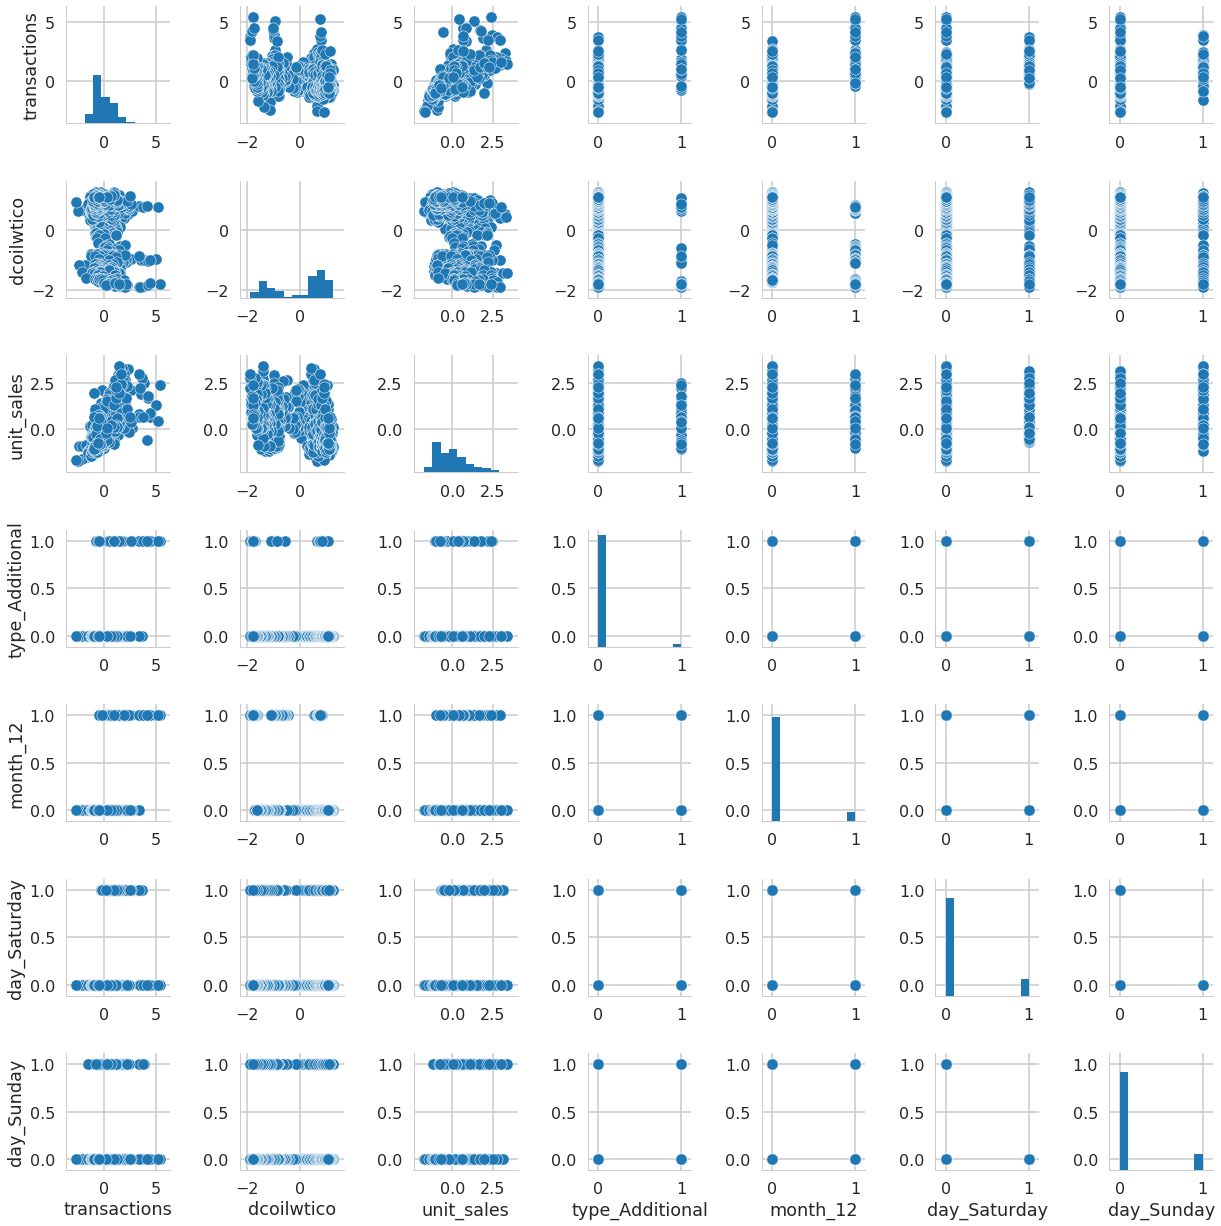

In [63]:
# Check the data distribution through pairplot
sns.pairplot(pd_train_filtered)

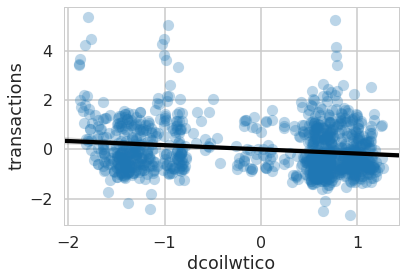

In [64]:
sns.regplot(x='dcoilwtico',
           y='transactions',
           data=pd_train,
           scatter_kws={'alpha':0.3},
           line_kws={'color':'black'})

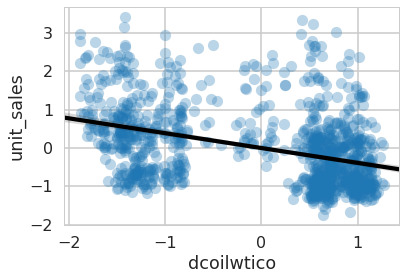

In [65]:
sns.regplot(x='dcoilwtico',
           y='unit_sales',
           data=pd_train,
           scatter_kws={'alpha':0.3},
           line_kws={'color':'black'})

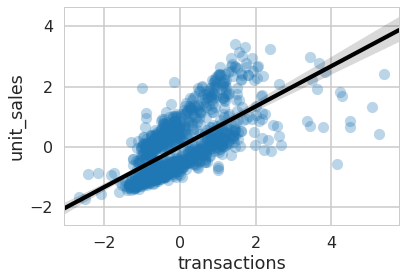

In [66]:
sns.regplot(x='transactions',
           y='unit_sales',
           data=pd_train,
           scatter_kws={'alpha':0.3},
           line_kws={'color':'black'})

# Checking for statistical significance

<b>Is there any statistically significant relation between Oil price and Transaction Volume for the store 44 ? </b>

Null Hypothesis H0 = Oil price and Transaction Volume are independent from each other.

Alternative Hypothesis HA = Oil price and Transaction Volume are not independent of each other. There is a relationship between them.

Oil Price - Independent continuous variable

Transaction Volume - Dependent continuous variable

In [67]:
lin_model = smf.ols(formula = 'transactions ~ dcoilwtico', data = pd_train).fit()

In [68]:
#print the summary 
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:           transactions   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     32.32
Date:                Wed, 08 Aug 2018   Prob (F-statistic):           1.68e-08
Time:                        06:51:27   Log-Likelihood:                -1529.3
No. Observations:                1089   AIC:                             3063.
Df Residuals:                    1087   BIC:                             3073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.108e-16      0.030  -3.71e-15      1.0

In [69]:
# Inference
# p-value is < 0.05 and hence there is relationship between transaction volume and oil price. 
# So, rejecting the null hypothesis

<b>Is there any statistically significant relation between Oil price and Sales for the store 44 ? </b>

Null Hypothesis H0 = Oil price and sales are independent from each other.

Alternative Hypothesis HA = Oil price and sales are not independent of each other. There is a relationship between them.

Oil Price - Independent continuous variable

Sales - Dependent continuous variable

In [70]:
lin_model = smf.ols(formula = 'unit_sales ~ dcoilwtico', data = pd_train).fit()

In [71]:
#print the summary 
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     191.3
Date:                Wed, 08 Aug 2018   Prob (F-statistic):           3.36e-40
Time:                        06:51:29   Log-Likelihood:                -1456.9
No. Observations:                1089   AIC:                             2918.
Df Residuals:                    1087   BIC:                             2928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.716e-16      0.028  -6.14e-15      1.0

In [72]:
# Inference
# p-value is < 0.05 and hence there is a relationship between oil price and sales. 
# So, rejecting the null hypothesis

# Train Test split

In [73]:
# Modeling for Transactions as the dependent variable and all the other variables from the filtered dataframe except total sales as the independent variables.

In [74]:
X_train = pd_train.drop(['unit_sales','transactions'], axis = 1)
y_labels = pd_train['transactions']

In [75]:
num_test = 0.35
X_train, X_test, y_train, Y_test = train_test_split(X_train, y_labels, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', Y_test.shape)

('X_train shape :', (707, 55))
('y_train shape :', (707,))
('X_test shape :', (382, 55))
('y_test shape :', (382,))


# Transaction Volume Prediction

# Model1a: Linear regression using the direct closed-form normal equation
# invoke the LinearRegression function and find the bestfit model on training data

In [76]:
regression_model = LinearRegression()
regression_model.fit(X_train.as_matrix(), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
print(regression_model.coef_)
print(regression_model.intercept_)

[-9.60034593e-02 -5.49010914e+11 -5.49010914e+11 -5.49010914e+11
 -5.49010914e+11  2.47462746e+12 -5.49010914e+11 -5.49010914e+11
 -2.18988857e+11  6.64353677e+11 -3.81721180e+11 -7.06510539e+11
  1.70336126e+11 -2.44556192e+11 -2.44556192e+11  2.49461359e+11
 -2.44556192e+11  8.01518665e+11 -2.44556192e+11 -2.44556192e+11
 -2.44556192e+11 -2.44556192e+11 -2.44556192e+11 -2.44556192e+11
 -2.44556192e+11 -2.44556192e+11 -5.90112330e+11 -2.44556192e+11
 -2.44556192e+11 -2.44556192e+11 -2.44556192e+11  2.49461359e+11
  2.49461359e+11  7.18331547e+11  7.18331547e+11 -5.88886473e+11
  5.69445055e+10  5.69445055e+10  5.69445055e+10  5.69445055e+10
  5.69445055e+10  5.69445055e+10  5.69445055e+10  5.69445055e+10
  5.69445055e+10  5.69445055e+10  5.69445055e+10  5.69445055e+10
  8.42902881e+11  8.42902881e+11  8.42902881e+11  8.42902881e+11
  8.42902881e+11  8.42902881e+11  8.42902881e+11]
-1269976647537.2515


In [78]:
# Checking the coefficients for each of the independent attributes

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for dcoilwtico is -0.0960034593203
The coefficient for type_Additional is -5.49010913821e+11
The coefficient for type_Bridge is -5.49010913823e+11
The coefficient for type_Event is -5.49010913824e+11
The coefficient for type_Holiday is -5.49010913823e+11
The coefficient for type_No_Holiday is 2.47462745863e+12
The coefficient for type_Transfer is -5.49010913826e+11
The coefficient for type_Work Day is -5.49010913823e+11
The coefficient for store_nbr_44 is -2.18988856656e+11
The coefficient for locale_Local is 6.64353677112e+11
The coefficient for locale_National is -3.81721179938e+11
The coefficient for locale_None is -7.065105386e+11
The coefficient for locale_Regional is 1.70336126173e+11
The coefficient for locale_name_Ambato is -2.44556191929e+11
The coefficient for locale_name_Cayambe is -2.44556191928e+11
The coefficient for locale_name_Cotopaxi is 2.49461359012e+11
The coefficient for locale_name_Cuenca is -2.44556191928e+11
The coefficient for locale_name_Ecuado

In [79]:
# Let us check the intercept for the model

intercept = regression_model.intercept_

print("The intercept for the model is {}".format(intercept))

The intercept for the model is -1.26997664754e+12


In [80]:
regression_model.score(X_test, Y_test)

0.6558644803692054

In [81]:
# checking the sum of squared errors by predicting value of y for test cases and 
# subtracting from the actual y for the test cases

mse = np.mean((regression_model.predict(X_test)-Y_test)**2)

In [82]:
# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual

import math

math.sqrt(mse)

0.5755537381618258

In [83]:
# predict transaction volume for a set of attributes 
y_pred = regression_model.predict(X_test)

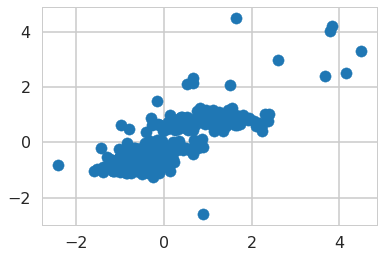

In [84]:
# Since this is regression, plot the predicted y value vs actual y values for the test data
plt.scatter(Y_test, y_pred)

In [85]:
from sklearn.metrics import r2_score
R2_Lin_Reg_Tran_Pred = r2_score(Y_test, y_pred)
print(R2_Lin_Reg_Tran_Pred)

0.6558644803692054


In [86]:
y_train_pred = regression_model.predict(X_train)

# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Train data
print(mean_absolute_error(y_train, y_train_pred))
print(mean_squared_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

0.34761541123205175
0.24531856745132752
0.49529644401239903


In [87]:
RMSE_Lin_Reg_Tran_Pred = np.sqrt(mean_squared_error(Y_test, y_pred))
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of simple linear regression model is : " + str(mean_absolute_error(Y_test, y_pred)))
print("The mean squared error of simple linear regression model is : " + str(mean_squared_error(Y_test, y_pred)))
print("The root mean squared error of simple linear regression model is : " + str(RMSE_Lin_Reg_Tran_Pred))

The mean absolute error of simple linear regression model is : 0.40218792597116115
The mean squared error of simple linear regression model is : 0.3312621055120514
The root mean squared error of simple linear regression model is : 0.5755537381618256


# Model 1b: Linear regression using stochastic gradient descent without regularization

In [88]:
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_train, y_train.ravel())

/usr/local/anaconda/python2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [89]:
print(sgd_reg.intercept_)
print(sgd_reg.coef_)

[-0.08731821]
[-0.10752723  1.58110804  0.02789466 -0.60399679  0.15531906  0.0563204
 -1.1002516  -0.20371198 -0.08731821 -0.35567218  0.26249513  0.0563204
 -0.05046155  0.06072164  0.21741115  0.06668207  0.19474665  0.26249513
  0.18487407  0.2228247  -0.43103156  0.23530325  0.10253378  0.05669403
 -0.29278876 -0.20621574  0.0563204   0.07197847  0.32051734 -1.36285083
  0.26960964 -0.03412233 -0.08302129  0.10099546 -0.24463407  0.0563204
 -0.23607443 -0.28626179 -0.09884285 -0.08598411 -0.06500686 -0.08311052
 -0.19800274 -0.02133331  0.02721005 -0.181897   -0.05557463  1.19755999
 -0.09065862 -0.42776724  1.05299553  0.8362252  -0.69419267 -0.68241543
 -0.08150497]


In [90]:
# Checking the coefficients for each of the independent attributes

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, sgd_reg.coef_[idx]))

The coefficient for dcoilwtico is -0.107527229905
The coefficient for type_Additional is 1.58110804062
The coefficient for type_Bridge is 0.0278946628035
The coefficient for type_Event is -0.603996785363
The coefficient for type_Holiday is 0.155319064305
The coefficient for type_No_Holiday is 0.0563203950128
The coefficient for type_Transfer is -1.10025160154
The coefficient for type_Work Day is -0.203711983549
The coefficient for store_nbr_44 is -0.0873182077152
The coefficient for locale_Local is -0.355672184674
The coefficient for locale_National is 0.262495134947
The coefficient for locale_None is 0.0563203950128
The coefficient for locale_Regional is -0.0504615530009
The coefficient for locale_name_Ambato is 0.0607216373621
The coefficient for locale_name_Cayambe is 0.217411153326
The coefficient for locale_name_Cotopaxi is 0.0666820696582
The coefficient for locale_name_Cuenca is 0.194746649717
The coefficient for locale_name_Ecuador is 0.262495134947
The coefficient for locale_n

In [91]:
sgd_reg.score(X_test, Y_test)

0.68279259232856

In [92]:
# checking the sum of squared errors by predicting value of y for test cases and 
# subtracting from the actual y for the test cases
mse = np.mean((sgd_reg.predict(X_test)-Y_test)**2)

In [93]:
# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
import math
math.sqrt(mse)

0.5525769808686058

In [94]:
# predict transaction volume for a set of attributes 
y_pred = sgd_reg.predict(X_test)

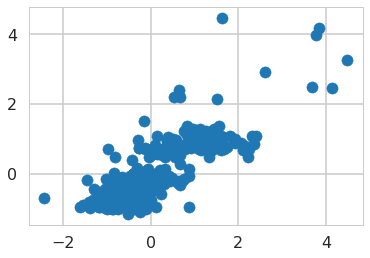

In [95]:
# Since this is regression, plot the predicted y value vs actual y values for the test data
plt.scatter(Y_test, y_pred)

In [96]:
from sklearn.metrics import r2_score
R2_Sgd_Tran_Pred = r2_score(Y_test, y_pred)
print(R2_Sgd_Tran_Pred)

0.68279259232856


In [97]:
y_train_pred = sgd_reg.predict(X_train)
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Train data
print(mean_absolute_error(y_train, y_train_pred))
print(mean_squared_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

0.360029398818339
0.25731219174288633
0.507259491525675


In [98]:
RMSE_Sgd_Tran_Pred = np.sqrt(mean_squared_error(Y_test, y_pred))
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of simple linear regression model is : " + str(mean_absolute_error(Y_test, y_pred)))
print("The mean squared error of simple linear regression model is : " + str(mean_squared_error(Y_test, y_pred)))
print("The root mean squared error of simple linear regression model is : " + str(RMSE_Sgd_Tran_Pred))

The mean absolute error of simple linear regression model is : 0.40013647072467945
The mean squared error of simple linear regression model is : 0.30534131978586365
The root mean squared error of simple linear regression model is : 0.5525769808686058


# Model 2 : Decision Tree with and without gridsearch CV

In [99]:
# Criterion : Mean absolute error

In [100]:
dtree = DecisionTreeRegressor(random_state=0, criterion="mae")
dtree_fit = dtree.fit(X_train, y_train)

In [101]:
dtree_scores = cross_val_score(dtree_fit, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dtree_scores)))
print("score without cv: {}".format(dtree_fit.score(X_train, y_train)))

mean cross validation score: 0.406187440504
score without cv: 1.0


In [102]:
# on the test or hold-out set
from sklearn.metrics import r2_score
y_pred = dtree_fit.predict(X_test)
R2_DT_WoutGCV_Tran_Pred = r2_score(Y_test, y_pred)
print(R2_DT_WoutGCV_Tran_Pred)
print(dtree_fit.score(X_test, Y_test))

0.5605361928119182
0.5605361928119182


In [103]:
final_mae = mean_absolute_error(Y_test, y_pred)
final_mse = mean_squared_error(Y_test, y_pred)
final_rmse = np.sqrt(final_mse)

In [104]:
RMSE_DT_WoutGCV_Tran_Pred = final_rmse
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of decision tree without gridsearchcv is : " + str(final_mae))
print("The mean squared error of decision tree without gridsearchcv is : " + str(final_mse))
print("The root mean squared error of decision tree without gridsearchcv is : " + str(final_rmse))

The mean absolute error of decision tree without gridsearchcv is : 0.45099078356098804
The mean squared error of decision tree without gridsearchcv is : 0.42302435453814535
The root mean squared error of decision tree without gridsearchcv is : 0.6504032245754516


In [105]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)

result = g_cv.cv_results_
# print(result)
R2_DT_WithGCV_Tran_Pred = r2_score(Y_test, g_cv.best_estimator_.predict(X_test))
print(R2_DT_WithGCV_Tran_Pred)

0.6682680307699073


In [106]:
y_pred = g_cv.best_estimator_.predict(X_test)

In [107]:
final_mae = mean_absolute_error(Y_test, y_pred)
final_mse = mean_squared_error(Y_test, y_pred)
final_rmse = np.sqrt(final_mse)

In [108]:
RMSE_DT_WithGCV_Tran_Pred = final_rmse
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of decision tree with gridsearchcv is : " + str(final_mae))
print("The mean squared error of decision tree with gridsearchcv is : " + str(final_mse))
print("The root mean squared error of decision tree with gridsearchcv is : " + str(final_rmse))

The mean absolute error of decision tree with gridsearchcv is : 0.3987709312490536
The mean squared error of decision tree with gridsearchcv is : 0.3193225468580377
The root mean squared error of decision tree with gridsearchcv is : 0.5650863180594958


In [109]:
print("The best params from gridsearchcv are :" + str(g_cv.best_params_))

The best params from gridsearchcv are :{'min_samples_split': 8}


In [110]:
print("The best estimators from gridsearchcv are :" + str(g_cv.best_estimator_))

The best estimators from gridsearchcv are :DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


In [111]:
# Printing the decision tree
dot_data = export_graphviz(dtree_fit, out_file=None)

In [112]:
graph = graphviz.Source(dot_data) 

In [113]:
dot_data = export_graphviz(dtree_fit, out_file=None, 
                         feature_names=X_train.columns,   
                         filled=True, rounded=True,  
                         special_characters=True)

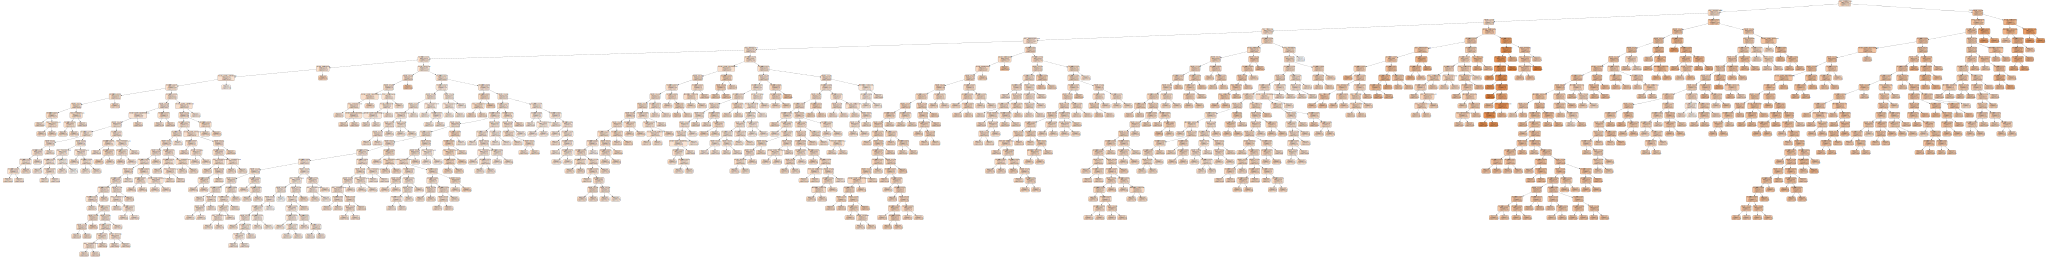

In [114]:
graph = graphviz.Source(dot_data)
graph 

# Inference:
# Oil price is the main predictor value using which decision tree is built and is an influencing factor in the total transaction volume.

# Model 3 : Random Forest with GridsearchCV

In [115]:
# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'criterion': ['mse','mae'],
              'max_depth': [5, 10, 15], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1,5]
             }

# Type of scoring used to compare parameter combinations

# Run the grid search
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, #Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   29.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [116]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = RFR.predict(X_test)
R2_RF_WithGCV_Tran_Pred = r2_score(Y_test, predictions)

print('R2 score = ',R2_RF_WithGCV_Tran_Pred, '/ 1.0')
print("The mean absolute error of random forest with gridsearchcv is : " + str(mean_absolute_error(Y_test, predictions)))
print("The mean squared error of random forest with gridsearchcv is : " + str(mean_squared_error(Y_test, predictions)))
print("The root mean squared error of random forest with gridsearchcv is : " + str(np.sqrt(mean_squared_error(Y_test, predictions))))

('R2 score = ', 0.7407277036111519, '/ 1.0')
The mean absolute error of random forest with gridsearchcv is : 0.3517972465249688
The mean squared error of random forest with gridsearchcv is : 0.2495734439004096
The root mean squared error of random forest with gridsearchcv is : 0.4995732617949139


In [117]:
RMSE_RF_WithGCV_Tran_Pred = np.sqrt(mean_squared_error(Y_test, predictions))

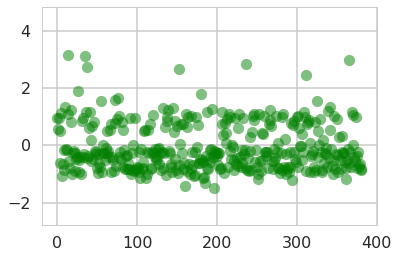

In [118]:
#Check and plot the 500 first predictions
plt.plot(Y_test.as_matrix()[0:500], '+', color ='red', alpha=0.7)
plt.plot(predictions[0:500], 'ro', color ='green', alpha=0.5)
plt.show()

# Sales Prediction

In [119]:
# Modeling for Total sales as the dependent variable and all the other variables except transactions as the independent variables.

In [120]:
X_train = pd_train.drop(['unit_sales','transactions'], axis = 1)
y_labels = pd_train['unit_sales']

In [121]:
num_test = 0.20
X_train, X_test, y_train, Y_test = train_test_split(X_train, y_labels, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('Y_test shape :', Y_test.shape)

('X_train shape :', (871, 55))
('y_train shape :', (871,))
('X_test shape :', (218, 55))
('Y_test shape :', (218,))


# Model1: Linear regression
# invoke the LinearRegression function and find the bestfit model on training data

In [122]:
regression_model = LinearRegression()
regression_model.fit(X_train.as_matrix(), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
print(regression_model.coef_)
print(regression_model.intercept_)

[-3.56671554e-01 -1.13197940e+10 -1.13197940e+10 -1.13197940e+10
 -1.13197940e+10 -5.93692747e+11 -1.13197940e+10 -1.13197940e+10
  8.67527305e+09 -4.14227069e+11  6.04197336e+11 -2.20108576e+12
 -2.44828712e+11  4.92031736e+10  4.92031736e+10 -1.20195183e+11
  4.92031736e+10 -9.69221231e+11  4.92031736e+10  4.92031736e+10
  4.92031736e+10  4.92031736e+10  4.92031736e+10  4.92031736e+10
  4.92031736e+10  4.92031736e+10  4.60354116e+11  4.92031736e+10
  4.92031736e+10  4.92031736e+10  4.92031736e+10 -1.20195183e+11
 -1.20195183e+11 -1.49717495e+12 -1.49717495e+12  4.60905745e+11
  1.75291489e+11  1.75291489e+11  1.75291489e+11  1.75291489e+11
  1.75291489e+11  1.75291489e+11  1.75291489e+11  1.75291489e+11
  1.75291489e+11  1.75291489e+11  1.75291489e+11  1.75291489e+11
 -1.12300798e+11 -1.12300798e+11 -1.12300798e+11 -1.12300798e+11
 -1.12300798e+11 -1.12300798e+11 -1.12300798e+11]
1801852679207.4539


In [124]:
# Checking the coefficients for each of the independent attributes

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for dcoilwtico is -0.35667155353
The coefficient for type_Additional is -11319793989.6
The coefficient for type_Bridge is -11319793989.8
The coefficient for type_Event is -11319793989.7
The coefficient for type_Holiday is -11319793989.3
The coefficient for type_No_Holiday is -5.93692747025e+11
The coefficient for type_Transfer is -11319793991.2
The coefficient for type_Work Day is -11319793990.3
The coefficient for store_nbr_44 is 8675273049.01
The coefficient for locale_Local is -4.14227068769e+11
The coefficient for locale_National is 6.04197335911e+11
The coefficient for locale_None is -2.20108575761e+12
The coefficient for locale_Regional is -2.44828712195e+11
The coefficient for locale_name_Ambato is 49203173571.9
The coefficient for locale_name_Cayambe is 49203173571.8
The coefficient for locale_name_Cotopaxi is -1.20195183002e+11
The coefficient for locale_name_Cuenca is 49203173571.5
The coefficient for locale_name_Ecuador is -9.69221231108e+11
The coefficient f

In [125]:
# Let us check the intercept for the model

intercept = regression_model.intercept_

print("The intercept for the model is {}".format(intercept))

The intercept for the model is 1.80185267921e+12


In [126]:
regression_model.score(X_test, Y_test)

0.48022163239096594

In [127]:
# checking the sum of squared errors by predicting value of y for test cases and 
# subtracting from the actual y for the test cases

mse = np.mean((regression_model.predict(X_test)-Y_test)**2)

In [128]:
# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual

import math

math.sqrt(mse)

0.7217543086609938

In [129]:
# predict transaction volume for a set of attributes 
y_pred = regression_model.predict(X_test)

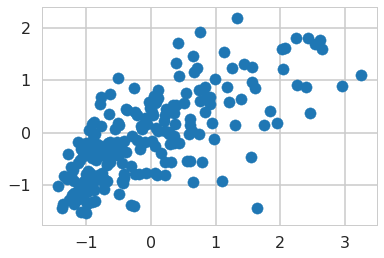

In [130]:
# Since this is regression, plot the predicted y value vs actual y values for the test data
plt.scatter(Y_test, y_pred)

In [131]:
from sklearn.metrics import r2_score
R2_Lin_Reg_Sale_Pred = r2_score(Y_test, y_pred)
print(R2_Lin_Reg_Sale_Pred)

0.48022163239096594


In [132]:
y_train_pred = regression_model.predict(X_train)
RMSE_Lin_Reg_Sale_Pred = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Train data
print(mean_absolute_error(y_train, y_train_pred))
print(mean_squared_error(y_train, y_train_pred))
print(RMSE_Lin_Reg_Sale_Pred)

0.5094281855570595
0.41483286813709686
0.6440752037899743


In [133]:
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of simple linear regression model is : " + str(mean_absolute_error(Y_test, y_pred)))
print("The mean squared error of simple linear regression model is : " + str(mean_squared_error(Y_test, y_pred)))
print("The root mean squared error of simple linear regression model is : " + str(np.sqrt(mean_squared_error(Y_test, y_pred))))

The mean absolute error of simple linear regression model is : 0.5402662087696632
The mean squared error of simple linear regression model is : 0.5209292820707088
The root mean squared error of simple linear regression model is : 0.7217543086609935


# Model 1b: Linear regression using stochastic gradient descent without regularization

In [134]:
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_train, y_train.ravel())

/usr/local/anaconda/python2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [135]:
print(sgd_reg.intercept_)
print(sgd_reg.coef_)

[-0.12142162]
[-0.31208552  0.21902805 -0.00572011  0.08854119  0.48504647  0.104221
 -0.55737674 -0.45516148 -0.12142162 -0.28096585  0.09888348  0.104221
 -0.04356025  0.1439799   0.0390537  -0.09307756 -0.13133879  0.09888348
  0.04680912 -0.07273212  0.19455258  0.05193425 -0.06002994 -0.06464013
 -0.45867428 -0.11299947  0.104221   -0.06448825 -0.05184745  0.01543181
  0.24402321  0.27344636 -0.22392904  0.14649808 -0.37214069  0.104221
 -0.07057067 -0.60763891 -0.18327678 -0.51359609 -0.41967586 -0.04175532
  0.21977505 -0.08950534  0.39438081  0.341917    0.20976123  0.63876327
 -0.2859369  -0.2511476   0.69921901  0.86660804 -0.63270941 -0.44444341
 -0.07301136]


In [136]:
sgd_reg.score(X_test, Y_test)

0.5011674821308041

In [137]:
# checking the sum of squared errors by predicting value of y for test cases and 
# subtracting from the actual y for the test cases
mse = np.mean((sgd_reg.predict(X_test)-Y_test)**2)

In [138]:
# underroot of mean_sq_error is standard deviation i.e. avg variance between predicted and actual
import math
math.sqrt(mse)

0.7070622696595126

In [139]:
# predict transaction volume for a set of attributes 
y_pred = sgd_reg.predict(X_test)

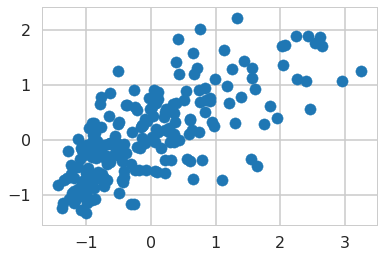

In [140]:
# Since this is regression, plot the predicted y value vs actual y values for the test data
plt.scatter(Y_test, y_pred)

In [141]:
from sklearn.metrics import r2_score
R2_Sgd_Sale_Pred = r2_score(Y_test, y_pred)
print(R2_Sgd_Sale_Pred)

0.5011674821308041


In [142]:
y_train_pred = sgd_reg.predict(X_train)
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Train data
print(mean_absolute_error(y_train, y_train_pred))
print(mean_squared_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

0.5392771529249275
0.44552923654690063
0.6674797648969597


In [143]:
RMSE_Sgd_Sale_Pred = np.sqrt(mean_squared_error(Y_test, y_pred))
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of simple linear regression model with SGD is : " + str(mean_absolute_error(Y_test, y_pred)))
print("The mean squared error of simple linear regression model with SGD is : " + str(mean_squared_error(Y_test, y_pred)))
print("The root mean squared error of simple linear regression model with SGD is : " + str(RMSE_Sgd_Sale_Pred))

The mean absolute error of simple linear regression model with SGD is : 0.557255351764031
The mean squared error of simple linear regression model with SGD is : 0.49993705317606163
The root mean squared error of simple linear regression model with SGD is : 0.7070622696595128


# Model 2 : Decision Tree with and without gridsearch CV

In [144]:
# Criterion : Mean absolute error

In [145]:
dtree = DecisionTreeRegressor(random_state=0, criterion="mae")
dtree_fit = dtree.fit(X_train, y_train)

In [146]:
dtree_scores = cross_val_score(dtree_fit, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dtree_scores)))
print("score without cv: {}".format(dtree_fit.score(X_train, y_train)))

mean cross validation score: 0.46102147517
score without cv: 1.0


In [147]:
y_pred = dtree_fit.predict(X_test)

In [148]:
# on the test or hold-out set
from sklearn.metrics import r2_score
R2_DT_WoutGCV_Sale_Pred = r2_score(Y_test,y_pred)
print(R2_DT_WoutGCV_Sale_Pred)
print(dtree_fit.score(X_test, Y_test))

0.4291128820755423
0.4291128820755423


In [149]:
final_mae = mean_absolute_error(Y_test, y_pred)
final_mse = mean_squared_error(Y_test, y_pred)
final_rmse = np.sqrt(final_mse)

In [150]:
RMSE_DT_WoutGCV_Sale_Pred = final_rmse

In [151]:
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of decision tree without gridsearchcv is : " + str(final_mae))
print("The mean squared error of decision tree without gridsearchcv is : " + str(final_mse))
print("The root mean squared error of decision tree without gridsearchcv is : " + str(final_rmse))

The mean absolute error of decision tree without gridsearchcv is : 0.4825549478482848
The mean squared error of decision tree without gridsearchcv is : 0.5721511994656449
The root mean squared error of decision tree without gridsearchcv is : 0.756406768521835


In [152]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
R2_DT_WithGCV_Sale_Pred = r2_score(Y_test, g_cv.best_estimator_.predict(X_test))
print(R2_DT_WithGCV_Sale_Pred)

0.6164032918669986


In [153]:
y_pred = g_cv.best_estimator_.predict(X_test)

In [154]:
final_mae = mean_absolute_error(Y_test, y_pred)
final_mse = mean_squared_error(Y_test, y_pred)
final_rmse = np.sqrt(final_mse)

In [155]:
RMSE_DT_WithGCV_Sale_Pred=final_rmse

In [156]:
# Print the results of MAE (mean absolute error), MSE (Mean squared Error), RMSE (Root Mean squared error) - Test data
print("The mean absolute error of decision tree with gridsearchcv is : " + str(final_mae))
print("The mean squared error of decision tree with gridsearchcv is : " + str(final_mse))
print("The root mean squared error of decision tree with gridsearchcv is : " + str(final_rmse))

The mean absolute error of decision tree with gridsearchcv is : 0.398571195315775
The mean squared error of decision tree with gridsearchcv is : 0.3844460836098453
The root mean squared error of decision tree with gridsearchcv is : 0.6200371630877017


In [157]:
print("The best params from gridsearchcv are :" + str(g_cv.best_params_))

The best params from gridsearchcv are :{'min_samples_split': 9}


In [158]:
print("The best estimators from gridsearchcv are :" + str(g_cv.best_estimator_))

The best estimators from gridsearchcv are :DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=9, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


In [159]:
# Printing the decision tree
dot_data = export_graphviz(dtree_fit, out_file=None)

In [160]:
graph = graphviz.Source(dot_data) 

In [161]:
dot_data = export_graphviz(dtree_fit, out_file=None, 
                         feature_names=X_train.columns,   
                         filled=True, rounded=True,  
                         special_characters=True)

In [162]:
graph = graphviz.Source(dot_data)
graph 

# Model 4: Sales Prediction with Random Forest & GridsearchCV

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
#YOU CAN TRY DIFFERENTS PARAMETERS TO FIND THE BEST MODEL
parameters = {'n_estimators': [5, 10, 100],
              'criterion': ['mse','mae'],
              'max_depth': [5, 10, 15], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1,5]
             }

# Type of scoring used to compare parameter combinations

# Run the grid search
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, #Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   42.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [164]:
print("The best params from gridsearchcv are :" + str(grid_obj.best_params_))
print("The best estimators from gridsearchcv are :" + str(grid_obj.best_estimator_))

The best params from gridsearchcv are :{'min_samples_split': 5, 'n_estimators': 100, 'criterion': 'mse', 'max_depth': 15, 'min_samples_leaf': 1}
The best estimators from gridsearchcv are :RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [165]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = RFR.predict(X_test)
R2_RF_WithGCV_Sale_Pred = r2_score(Y_test, predictions)

print('R2 score = ',R2_RF_WithGCV_Sale_Pred, '/ 1.0')
print('MSE score = ',mean_squared_error(Y_test, predictions), '/ 0.0')

('R2 score = ', 0.6979325035050576, '/ 1.0')
('MSE score = ', 0.30273634666605864, '/ 0.0')


In [166]:
RMSE_RF_WithGCV_Sale_Pred = np.sqrt(mean_squared_error(Y_test, predictions))

In [167]:
print("The mean absolute error of random forest with gridsearchcv is : " + str(mean_absolute_error(Y_test, predictions)))
print("The mean squared error of random forest with gridsearchcv is : " + str(mean_squared_error(Y_test, predictions)))
print("The root mean squared error of random forest with gridsearchcv is : " + str(RMSE_RF_WithGCV_Sale_Pred))

The mean absolute error of random forest with gridsearchcv is : 0.34986893913357636
The mean squared error of random forest with gridsearchcv is : 0.30273634666605864
The root mean squared error of random forest with gridsearchcv is : 0.5502148186536406


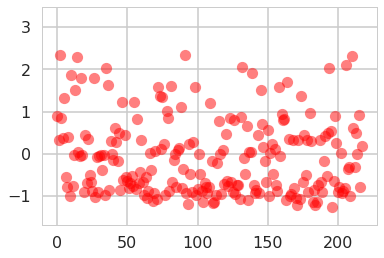

In [168]:
#Check and plot the 500 first predictions
plt.plot(Y_test.as_matrix()[0:500], '+', color ='blue', alpha=0.7)
plt.plot(predictions[0:500], 'ro', color ='red', alpha=0.5)
plt.show()

# Results

<b><u>Transaction Prediction: Different Models: Metrics : R-squared </b></u>

In [169]:
print("Linear regression : R2 score : " + str(R2_Lin_Reg_Tran_Pred))

print("Linear regression with stochastic gradient descent: R2 score : " + str(R2_Sgd_Tran_Pred))

print("Decision Tree without GridsearchCV : R2 score : " + str(R2_DT_WoutGCV_Tran_Pred))

print("Decision Tree with GridsearchCV : R2 score : " + str(R2_DT_WithGCV_Tran_Pred))

print("Random Forest with GridsearchCV : R2 score : "+ str(R2_RF_WithGCV_Tran_Pred))

Linear regression : R2 score : 0.6558644803692054
Linear regression with stochastic gradient descent: R2 score : 0.68279259232856
Decision Tree without GridsearchCV : R2 score : 0.5605361928119182
Decision Tree with GridsearchCV : R2 score : 0.6682680307699073
Random Forest with GridsearchCV : R2 score : 0.7407277036111519


<b><u>Sales Prediction: Different Models: Metrics: R-Squared</b></u>

In [170]:
print("Linear regression : R2 score : " + str(R2_Lin_Reg_Sale_Pred))

print("Linear regression with stochastic gradient descent : R2 score : " + str(R2_Sgd_Sale_Pred))

print("Decision Tree without GridsearchCV : R2 score : " + str(R2_DT_WoutGCV_Sale_Pred))

print("Decision Tree with GridsearchCV : R2 score : " + str(R2_DT_WithGCV_Sale_Pred))

print("Random Forest with GridsearchCV : R2 score : "+ str(R2_RF_WithGCV_Sale_Pred))

Linear regression : R2 score : 0.48022163239096594
Linear regression with stochastic gradient descent : R2 score : 0.5011674821308041
Decision Tree without GridsearchCV : R2 score : 0.4291128820755423
Decision Tree with GridsearchCV : R2 score : 0.6164032918669986
Random Forest with GridsearchCV : R2 score : 0.6979325035050576


<b><u>Transaction Prediction: Different Models: Metrics : RMSE </b></u>

In [171]:
print("Linear regression : RMSE : " + str(RMSE_Lin_Reg_Tran_Pred))

print("Linear regression with Stochastic Gradient Descent : RMSE : " + str(RMSE_Sgd_Tran_Pred))

print("Decision Tree without GridsearchCV : RMSE : " + str(RMSE_DT_WoutGCV_Tran_Pred))

print("Decision Tree with GridsearchCV : RMSE : " + str(RMSE_DT_WithGCV_Tran_Pred))

print("Random Forest with GridsearchCV : RMSE : "+ str(RMSE_RF_WithGCV_Tran_Pred))

Linear regression : RMSE : 0.5755537381618256
Linear regression with Stochastic Gradient Descent : RMSE : 0.5525769808686058
Decision Tree without GridsearchCV : RMSE : 0.6504032245754516
Decision Tree with GridsearchCV : RMSE : 0.5650863180594958
Random Forest with GridsearchCV : RMSE : 0.4995732617949139


<b><u> Sales Prediction: Different Models: Metrics: RMSE </b></u>

In [172]:
print("Linear regression : RMSE : " + str(RMSE_Lin_Reg_Tran_Pred))

print("Linear regression with stochastic gradient descent: RMSE : " + str(RMSE_Sgd_Tran_Pred))

print("Decision Tree without GridsearchCV : RMSE : " + str(RMSE_DT_WoutGCV_Tran_Pred))

print("Decision Tree with GridsearchCV : RMSE : " + str(RMSE_DT_WithGCV_Tran_Pred))

print("Random Forest with GridsearchCV : RMSE : "+ str(RMSE_RF_WithGCV_Tran_Pred))

Linear regression : RMSE : 0.5755537381618256
Linear regression with stochastic gradient descent: RMSE : 0.5525769808686058
Decision Tree without GridsearchCV : RMSE : 0.6504032245754516
Decision Tree with GridsearchCV : RMSE : 0.5650863180594958
Random Forest with GridsearchCV : RMSE : 0.4995732617949139


# Conclusion

In [173]:
print("The best regression model for predicting transaction volume & Sales is Random Forest with GridsearchCV")
print("The R2 score of this model for predicting transaction volume is " + str(R2_RF_WithGCV_Tran_Pred))
print("The R2 score of this model for predicting Sales is " + str(R2_RF_WithGCV_Sale_Pred))
print("The RMSE value of this model for predicting transaction volume is " + str(RMSE_RF_WithGCV_Tran_Pred))
print("The RMSE value of this model for predicting sales is " + str(RMSE_RF_WithGCV_Tran_Pred))

The best regression model for predicting transaction volume & Sales is Random Forest with GridsearchCV
The R2 score of this model for predicting transaction volume is 0.7407277036111519
The R2 score of this model for predicting Sales is 0.6979325035050576
The RMSE value of this model for predicting transaction volume is 0.4995732617949139
The RMSE value of this model for predicting sales is 0.4995732617949139
